In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import segmentation_utils
from skimage.segmentation import watershed
from scipy import ndimage
from skimage.feature import peak_local_max
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth


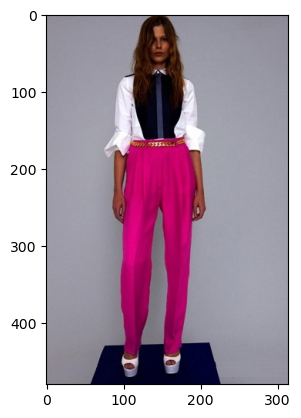

In [12]:
image = cv.imread('images/tshirt.jpg')
scale_percent = 50
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv.resize(image, dim, interpolation = cv.INTER_AREA)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb)

### Метод разрастания областей

In [13]:
def auto_segment(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, threshold):
    image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)
    # определяем координаты начальных точек
    seeds = [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5)]
    # координаты для графика
    x = list(map(lambda x: x[1], seeds))
    y = list(map(lambda x: x[0], seeds))
    # находим сегментацию используя метод из segmentation_utils
    segmented_region = segmentation_utils.region_growingHSV(image_hsv, seeds, threshold)
    # накладываем маску - отображаем только участки попавшие в какой-либо сегмент
    result = cv.bitwise_and(image_rgb, image_rgb, mask=segmented_region)
    # отображаем полученное изображение
    plt.figure(figsize=(15,20))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, marker="x", color="red", s=200)
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()

In [14]:
interact(auto_segment, x1=200, y1=125, x2=200, y2=145, x3=200, y3=160, x4=305, y4=105, x5=405, y5=170, threshold=105)

interactive(children=(IntSlider(value=200, description='x1', max=600, min=-200), IntSlider(value=125, descript…

<function __main__.auto_segment(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, threshold)>

### Метод деления

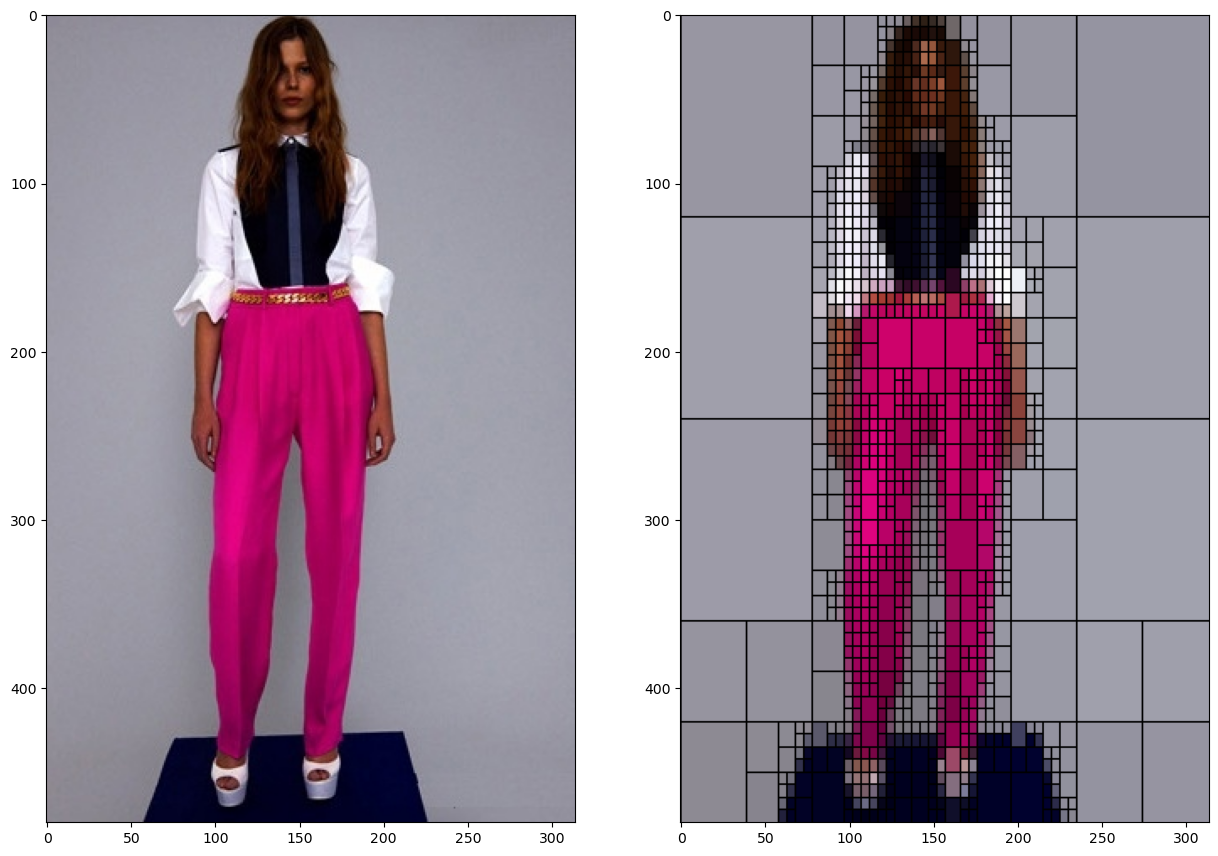

In [15]:
qt = segmentation_utils.QTree(stdThreshold = 0.05, minPixelSize = 4,img = image_rgb.copy()) 
qt.subdivide()
tree_image = qt.render_img(thickness=1, color=(0,0,0))

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.subplot(1, 2, 2)
plt.imshow(tree_image)
plt.show()

### Алгоритм водораздела

In [16]:
gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)

C:\Users\grego\AppData\Local\Temp\ipykernel_13120\1442800039.py:8: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=50, labels=binary_image)


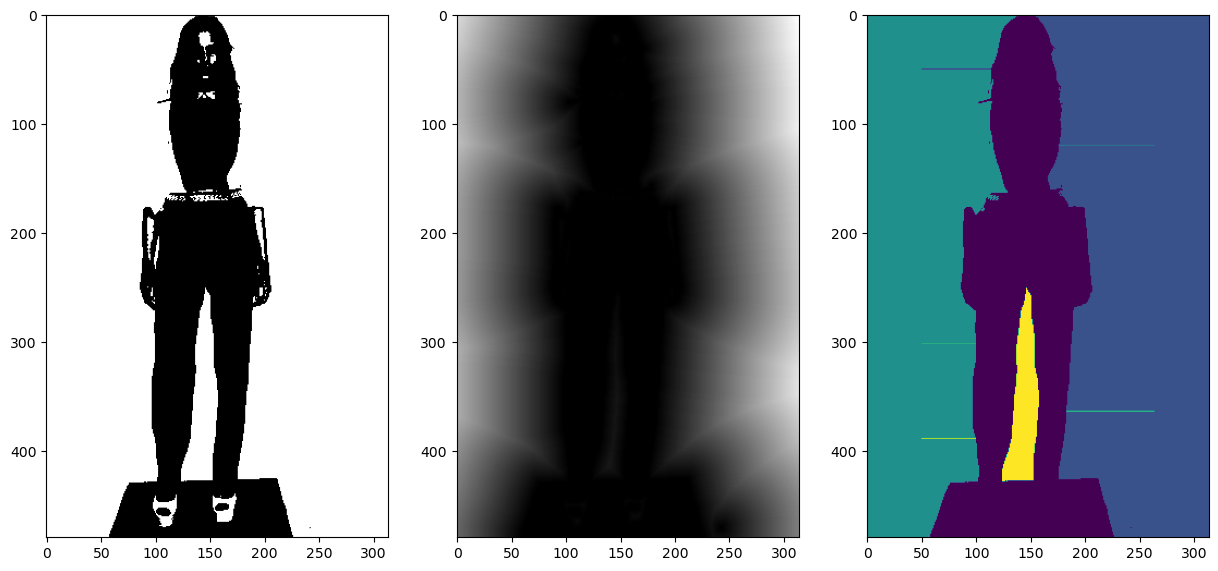

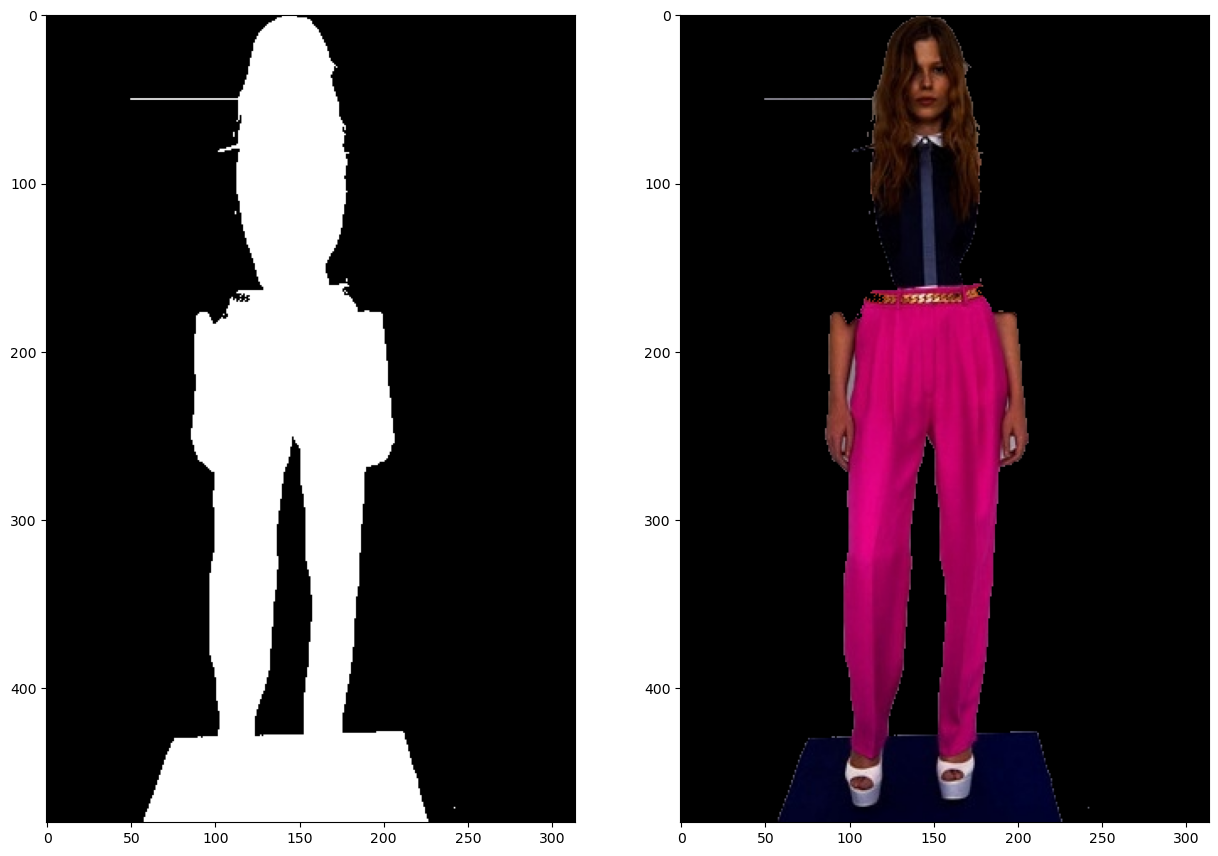

In [17]:
# Алгоритм водораздела
# Бинаризируем изображение
binary_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

# Определяем карту расстояний
distance_map = ndimage.distance_transform_edt(binary_image)
# Определяем локальные максимумы
local_max = peak_local_max(distance_map, indices=False, min_distance=50, labels=binary_image)
# 4 Каждому минимуму присваивается метка и начинается заполнение бассейнов метками
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=binary_image)
# построим результаты работы алгоритма
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(distance_map + 50), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(np.uint8(labels))
plt.show()

# Найдем границы контуров и положим в маску все кроме метки 0
mask1 = np.zeros(image_rgb.shape[0:2], dtype="uint8")
total_area = 0
for label in np.unique(labels):
    if label < 2:
        continue
    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    mask1 = mask1 + mask

    # Find contours and determine contour area
    cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)
    area = cv.contourArea(c)
    total_area += area

mask1 = cv.bitwise_not(mask1)
result = cv.bitwise_and(image_rgb, image_rgb, mask=mask1)

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(mask1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

### Метод к-средних

C:\Users\grego\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[ 64]
 [146]
 [ 10]
 [228]
 [160]
 [114]]


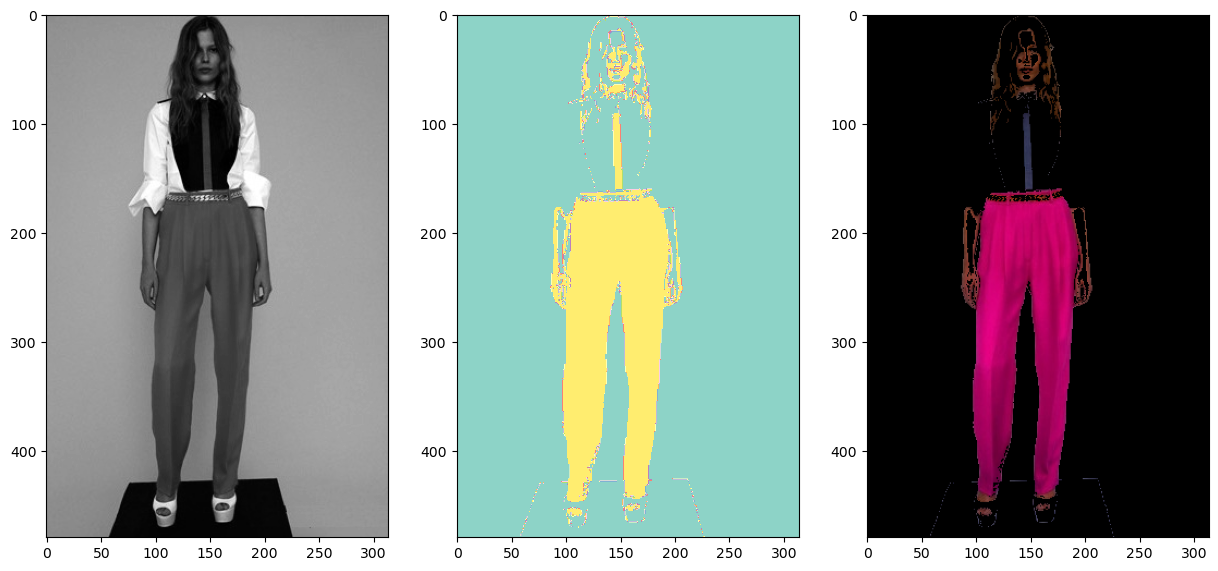

In [18]:
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 6
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
# Удалим самые яркие пиксели
segments[(segments==146) | (segments==10) | (segments==228) | (segments==160) | (segments==114)] = 0
result = cv.bitwise_and(image_rgb, image_rgb, mask=segments)
# Отобразим избражения 
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.show()

In [19]:
blur_image = cv.medianBlur(image_rgb, 9)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image_rgb.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]

Number of segments:  24


#### Удаление лишних яркостей

[[     3   8774]
 [    33    328]
 [    48   4267]
 [    51    630]
 [   105   1531]
 [   106    654]
 [   125   3440]
 [   141   2187]
 [   142    454]
 [   154 104413]
 [   159  10099]
 [   165    373]
 [   167    321]
 [   172     36]
 [   173     70]
 [   177     94]
 [   190     32]
 [   191    705]
 [   199   8379]
 [   216     99]
 [   230   3834]]


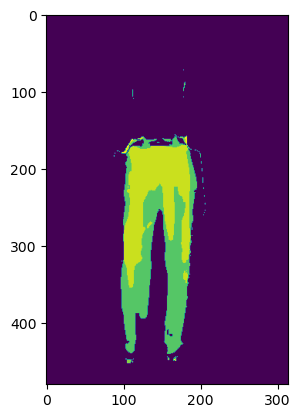

In [25]:
mask2=mask1.copy()
unique, counts = np.unique(mask2, return_counts=True)
print(np.asarray((unique, counts)).T)
mask2[(mask2==48)
    | (mask2==3)
    | (mask2==105)
    | (mask2==106)
    | (mask2==125)
    | (mask2==141)
    | (mask2==142)
    | (mask2==154)
    | (mask2==165)
    | (mask2==167)
    | (mask2==191)
    | (mask2==51)
    | (mask2==33)
    | (mask2==230)
]= 0
plt.imshow(mask2)

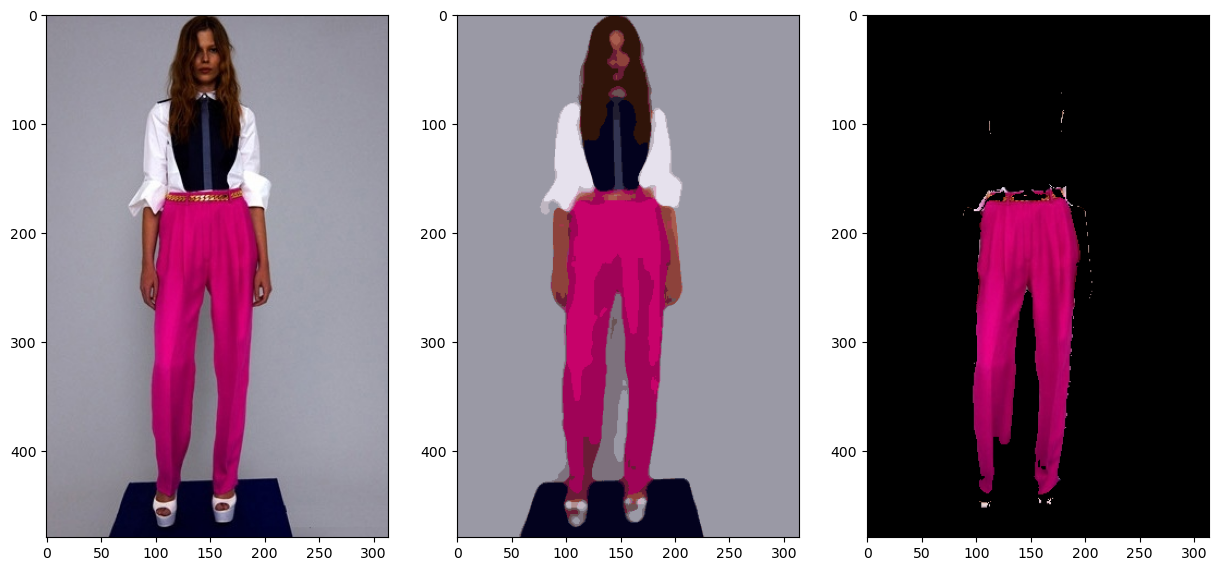

In [26]:
mean_shift_with_mask_image = cv.bitwise_and(image_rgb, image_rgb, mask=mask2)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(mean_shift_with_mask_image)
plt.show()